<h1> GAN implementation for Simpsons dataset</h1>
In this project a Generative Adversarial Network is implemented and traind using the Simpsons dataset. This dataset has been taken from the following link:
  
  https://www.kaggle.com/kostastokis/simpsons-faces

Keras with Tensorflow backend has been used for this implementation. In the next code cell the dataset will be downloaded and preprocessed. 

In [1]:
import urllib.request as req
from google.colab import drive
drive.mount('/content/drive')

# Set this to true if u want to copy form drive otherwise False
download = False

if download:
  # Downloading the dataset from specified URL
  print("Downloading the dataset")
  url = "https://storage.googleapis.com/kaggle-datasets/57177/110068/simpsons-faces.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1563534223&Signature=aH6jCy3aXCF0ZTuiDtAw521TMDzPTn7mqOYxlaGJn63w55bJeY7PSRsX5SY9nhJjN0ptgJoqPs4b863ggHwFsRXRM0nCwOtmSAAOjG2P8dkttIv80ZGnUB8UZqavAQHs%2B4J6KMDb07r4Ex80udgzLhImbB5EvDxim1k%2BvbkhuXFvoP7kUr2J2KG36vWusQmx9gurzI%2BOGlPs1FsJ6Etqd9elcQWJrnFw5fnB5MKRczgvRzDyFLp0xwqazTdD44jKijoBlnqQx8FBgVxRQqJQM4%2BdWrmmuXo7hTFdKFcCIfX5q5SJMpz%2BPXy1Ky56LEL8bZnhVWvcwtHV3i%2BYU7cmMQ%3D%3D"
  req.urlretrieve(url, 'dataset.zip')
  
else:
  !cp /content/drive/My\ Drive/MSc_Projects/ANN-HW6-GAN/Dataset/dataset.zip .
  pass


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Extracting the dataset and making ready for model training
!mkdir dataset
!unzip dataset.zip -d /content/dataset

# !mkdir simplified
# !unzip dataset/simplified.zip -d /content/simplified

!mkdir cropped
!unzip dataset/cropped.zip -d /content/cropped

Archive:  dataset.zip
  inflating: /content/dataset/cropped.zip  
  inflating: /content/dataset/simplified.zip  
Archive:  dataset/cropped.zip
  inflating: /content/cropped/3975.png  
  inflating: /content/cropped/8820.png  
  inflating: /content/cropped/9280.png  
  inflating: /content/cropped/348.png  
  inflating: /content/cropped/1804.png  
  inflating: /content/cropped/4968.png  
  inflating: /content/cropped/9294.png  
  inflating: /content/cropped/1810.png  
  inflating: /content/cropped/6819.png  
  inflating: /content/cropped/8834.png  
  inflating: /content/cropped/3961.png  
  inflating: /content/cropped/6831.png  
  inflating: /content/cropped/1186.png  
  inflating: /content/cropped/412.png  
  inflating: /content/cropped/3949.png  
  inflating: /content/cropped/3791.png  
  inflating: /content/cropped/4798.png  
  inflating: /content/cropped/4940.png  
  inflating: /content/cropped/5486.png  
  inflating: /content/cropped/374.png  
  inflating: /content/cropped/1838.png  

By this step the dataset has been downloaded and extracted. Now the goal is to construct the model and use the dataset.

In [0]:
import os
import time
import tensorflow as tf
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image #used for FORMARRAY in show_samples function
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def generator(z, output_channel_dim, training):
    with tf.variable_scope("generator", reuse= not training):
        
        # 8x8x1024
        fully_connected = tf.layers.dense(z, 8*8*1024)
        fully_connected = tf.reshape(fully_connected, (-1, 8, 8, 1024))
        fully_connected = tf.nn.leaky_relu(fully_connected)

        # 8x8x1024 -> 16x16x512
        trans_conv1 = tf.layers.conv2d_transpose(inputs=fully_connected,
                                                 filters=512,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv1")
        batch_trans_conv1 = tf.layers.batch_normalization(inputs = trans_conv1,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv1")
        trans_conv1_out = tf.nn.leaky_relu(batch_trans_conv1,
                                           name="trans_conv1_out")
        
        # 16x16x512 -> 32x32x256
        trans_conv2 = tf.layers.conv2d_transpose(inputs=trans_conv1_out,
                                                 filters=256,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv2")
        batch_trans_conv2 = tf.layers.batch_normalization(inputs = trans_conv2,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv2")
        trans_conv2_out = tf.nn.leaky_relu(batch_trans_conv2,
                                           name="trans_conv2_out")
        
        # 32x32x256 -> 64x64x128
        trans_conv3 = tf.layers.conv2d_transpose(inputs=trans_conv2_out,
                                                 filters=128,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv3")
        batch_trans_conv3 = tf.layers.batch_normalization(inputs = trans_conv3,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv3")
        trans_conv3_out = tf.nn.leaky_relu(batch_trans_conv3,
                                           name="trans_conv3_out")
        
        # 64x64x128 -> 128x128x64
        trans_conv4 = tf.layers.conv2d_transpose(inputs=trans_conv3_out,
                                                 filters=64,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv4")
        batch_trans_conv4 = tf.layers.batch_normalization(inputs = trans_conv4,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv4")
        trans_conv4_out = tf.nn.leaky_relu(batch_trans_conv4,
                                           name="trans_conv4_out")
        
        # 128x128x64 -> 128x128x3
        logits = tf.layers.conv2d_transpose(inputs=trans_conv4_out,
                                            filters=3,
                                            kernel_size=[5,5],
                                            strides=[1,1],
                                            padding="SAME",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                            name="logits")
        out = tf.tanh(logits, name="out")
        return out

In [0]:
def discriminator(x, reuse):
    with tf.variable_scope("discriminator", reuse=reuse): 
        
        # 128*128*3 -> 64x64x64 
        conv1 = tf.layers.conv2d(inputs=x,
                                 filters=64,
                                 kernel_size=[5,5],
                                 strides=[2,2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv1')
        batch_norm1 = tf.layers.batch_normalization(conv1,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm1')
        conv1_out = tf.nn.leaky_relu(batch_norm1,
                                     name="conv1_out")
        
        # 64x64x64-> 32x32x128 
        conv2 = tf.layers.conv2d(inputs=conv1_out,
                                 filters=128,
                                 kernel_size=[5, 5],
                                 strides=[2, 2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv2')
        batch_norm2 = tf.layers.batch_normalization(conv2,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm2')
        conv2_out = tf.nn.leaky_relu(batch_norm2,
                                     name="conv2_out")
        
        # 32x32x128 -> 16x16x256  
        conv3 = tf.layers.conv2d(inputs=conv2_out,
                                 filters=256,
                                 kernel_size=[5, 5],
                                 strides=[2, 2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv3')
        batch_norm3 = tf.layers.batch_normalization(conv3,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm3')
        conv3_out = tf.nn.leaky_relu(batch_norm3,
                                     name="conv3_out")
        
        # 16x16x256 -> 16x16x512
        conv4 = tf.layers.conv2d(inputs=conv3_out,
                                 filters=512,
                                 kernel_size=[5, 5],
                                 strides=[1, 1],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv4')
        batch_norm4 = tf.layers.batch_normalization(conv4,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm4')
        conv4_out = tf.nn.leaky_relu(batch_norm4,
                                     name="conv4_out")
        
        # 16x16x512 -> 8x8x1024
        conv5 = tf.layers.conv2d(inputs=conv4_out,
                                filters=1024,
                                kernel_size=[5, 5],
                                strides=[2, 2],
                                padding="SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                name='conv5')
        batch_norm5 = tf.layers.batch_normalization(conv5,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm5')
        conv5_out = tf.nn.leaky_relu(batch_norm5,
                                     name="conv5_out")

        flatten = tf.reshape(conv5_out, (-1, 8*8*1024))
        logits = tf.layers.dense(inputs=flatten,
                                 units=1,
                                 activation=None)
        out = tf.sigmoid(logits)
        return out, logits


In [0]:
def model_loss(input_real, input_z, output_channel_dim):
    g_model = generator(input_z, output_channel_dim, True)

    noisy_input_real = input_real + tf.random_normal(shape=tf.shape(input_real),
                                                     mean=0.0,
                                                     stddev=random.uniform(0.0, 0.1),
                                                     dtype=tf.float32)
    
    d_model_real, d_logits_real = discriminator(noisy_input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*random.uniform(0.9, 1.0)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = tf.reduce_mean(0.5 * (d_loss_real + d_loss_fake))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss

In [0]:
def model_optimizers(d_loss, g_loss):
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=LR_D, beta1=BETA1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=LR_G, beta1=BETA1).minimize(g_loss, var_list=g_vars)  
    return d_train_opt, g_train_opt

In [0]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate_G = tf.placeholder(tf.float32, name="lr_g")
    learning_rate_D = tf.placeholder(tf.float32, name="lr_d")
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D

In [0]:
def show_samples(sample_images, name, epoch, show=True):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (20, 20))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
        image.save(name+"_"+str(epoch)+"_"+str(index)+".png") 
    plt.savefig(name+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [0]:
def test(sess, input_z, out_channel_dim, epoch):
    example_z = np.random.uniform(-1, 1, size=[SAMPLES_TO_SHOW, input_z.get_shape().as_list()[-1]])
    samples = sess.run(generator(input_z, out_channel_dim, False), feed_dict={input_z: example_z})
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, OUTPUT_DIR + "samples", epoch)

In [0]:
def generate_100_samples(sess, input_z, out_channel_dim):
    example_z = np.random.uniform(-1, 1, size=[100, input_z.get_shape().as_list()[-1]])
    samples = sess.run(generator(input_z, out_channel_dim, False), feed_dict={input_z: example_z})
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, EVALUATION_DIR + "samples", 0, False)

In [0]:
def summarize_epoch(epoch, duration, sess, d_losses, g_losses, input_z, data_shape):
    minibatch_size = int(data_shape[0]//BATCH_SIZE)
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])))
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    test(sess, input_z, data_shape[3], epoch)

In [0]:
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return batches

In [0]:
!cp -rd /content/drive/My\ Drive/MSc_Projects/ANN-HW6-GAN/GAN6/model/ /content/ 

def train(get_batches, data_shape, checkpoint_to_load=None):
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], NOISE_SIZE)
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3])
    d_opt, g_opt = model_optimizers(d_loss, g_loss)
    
    saver = tf.train.Saver(max_to_keep=2)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        epoch = 0
        iteration = 0
        d_losses = []
        g_losses = []

        
        if LOAD:
          saver = tf.train.import_meta_graph(model_dir + "/GAN_model-500.meta")
          saver.restore(sess, tf.train.latest_checkpoint(model_dir))
          
        for epoch in range(EPOCHS):        
            epoch += 1
            start_time = time.time()

            for batch_images in get_batches:
                iteration += 1
                batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: LR_D})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: LR_G})
                d_losses.append(d_loss.eval({input_z: batch_z, input_images: batch_images}))
                g_losses.append(g_loss.eval({input_z: batch_z}))
                
            saver.save(sess, model_dir + "GAN_model", global_step=500)
            summarize_epoch(epoch, time.time()-start_time, sess, d_losses, g_losses, input_z, data_shape)
        generate_100_samples(sess, input_z, 3)

In [15]:
# Paths
INPUT_DATA_DIR = "/content/cropped/"
!rm -r -d /content/cropped/__MACOSX
# OUTPUT_DIR = './{date:%Y-%m-%d_%H:%M:%S}/'.format(date=datetime.datetime.now())
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)
!mkdir output
OUTPUT_DIR = "/content/output/"

!mkdir model
model_dir = "/content/model/"

!mkdir eval_samples
EVALUATION_DIR = "/content/eval_samples/"

mkdir: cannot create directory ‘model’: File exists


In [0]:
# Hyperparameters
IMAGE_SIZE = 128
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
EPOCHS = 0 # For better results increase this value 
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 5
LOAD = True

Start!
Input: (9877, 128, 128, 3)


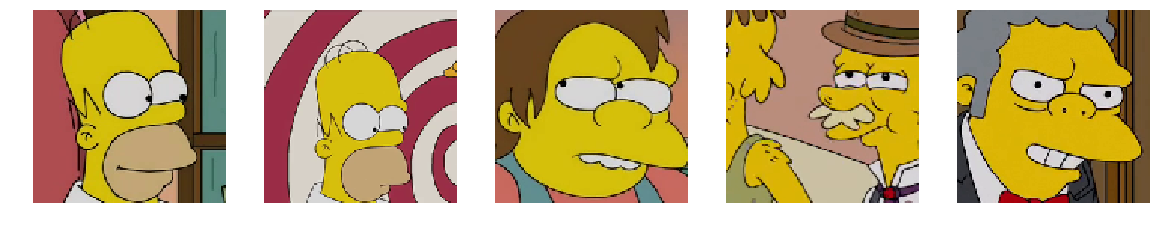

W0720 18:13:27.009577 140503573424000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


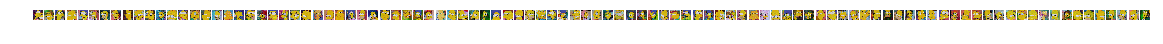

In [20]:
# Training
print("Start!")
input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob(INPUT_DATA_DIR + '*')])
print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

with tf.Graph().as_default():
    train(get_batches(input_images), input_images.shape)

This cell is to copy the saved model and output in disk to the google drive

In [21]:
import urllib.request as req
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# !cp -rd /content/model/ /content/drive/My\ Drive/MSc_Projects/ANN-HW6-GAN/GAN6/
# !cp -rd /content/output/ /content/drive/My\ Drive/MSc_Projects/ANN-HW6-GAN/GAN6/
!cp -rd /content/eval_samples/ /content/drive/My\ Drive/MSc_Projects/ANN-HW6-GAN/GAN6/

Mounted at /content/drive


This cell connects the results to Tensorboard

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

# !mkdir model
!cp -rd /content/drive/My\ Drive/MSc_Projects/ANN-HW6-GAN/model /content/ 

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format("./model/")
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
